In [1]:
import numpy as np
import os
import requests

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

api_url = "https://notify-api.line.me/api/notify"
token = "LYy0yPmrqjMc3rmvdQR2WcbCCVZkmFlf6FZBZGEkpYQ"
headers = {'Authorization':'Bearer '+token}


In [11]:
actions = [
    'fall','stand','walking','lie','sit'
]
data = np.load("./dataset/joint_dataset/seq_fall-2023-1.npy")
datas = np.load("./dataset/joint_dataset/seq_stand-2023-1.npy")
datas2 = np.load("./dataset/joint_dataset/seq_walking-2023-1.npy")
datas3 = np.load("./dataset/joint_dataset/seq_lie-2023-1.npy")
datas4 = np.load("./dataset/joint_dataset/seq_sit-2023-1.npy")
for i in range(2,105):
    data = np.concatenate([
        data,
        np.load(f'./dataset/joint_dataset/seq_fall-2023-{i}.npy')
    ], axis=0) 
print("1",data.shape) 
# for i in range(2,3):
#     data = np.concatenate([
#         data,
#         np.load(f'./dataset/joint_dataset/seq_stand-2023-{i}.npy')
#     ], axis=0)
for i in range(2,3):
    data = np.concatenate([
        data,
        np.load(f'./dataset/joint_dataset/seq_walking-2023-{i}.npy')
    ], axis=0)
print("2",data.shape) 
for i in range(2,3):
    data = np.concatenate([
        data,
        np.load(f'./dataset/joint_dataset/seq_lie-2023-{i}.npy')
    ], axis=0) 
print("3",data.shape) 
for i in range(2,48):
    data = np.concatenate([
        data,
        np.load(f'./dataset/joint_dataset/seq_sit-2023-{i}.npy')
    ], axis=0) 
print("4",data.shape) 
        
data = np.concatenate([data,datas2,datas3,datas4])
print(data.shape)

1 (2756, 30, 137)
2 (4406, 30, 137)
3 (5999, 30, 137)
4 (8410, 30, 137)
(10487, 30, 137)


In [11]:
# data = np.load("dataset/seq_fall-2023-1.npy")
# datas = np.load("dataset/seq_stand-2023-1.npy")
# datas2 = np.load("dataset/seq_walking-2023-1.npy")
# datas3 = np.load("dataset/seq_lie-2023-1.npy")


# for i in range(2,60):
#     data = np.concatenate([
#         data,
#         np.load(f'dataset/seq_fall-2023-{i}.npy')
#     ], axis=0)  
# print(data.shape)

# # fall = 1569
# # walking = 2428
# # lie = 5710
# for i in range(2,5):
#     datas3 = np.concatenate([
#         datas3,
#         np.load(f'dataset/seq_lie-2023-{i}.npy')
#     ], axis=0) 

# print(datas.shape)

In [12]:

# print(data[9000:11000,0,-1])
# print(data.shape)
data = np.nan_to_num(data)


x_data = data[:, :, :-1]
labels = data[:, 0, -1]

# print(x_data.shape)
# print(x_data[0,0,:])
# print(labels.shape)
# print(labels[5000:10000])


In [13]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(10487, 5)

In [14]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2,random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(8389, 30, 136) (8389, 5)
(2098, 30, 136) (2098, 5)


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=5213)

for train_idx, test_idx in split.split(x_data,y_data):
    x_train = x_data[train_idx]
    y_train = y_data[train_idx]
    x_val = x_data[test_idx]
    y_val = y_data[test_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6292, 30, 136) (6292, 5)
(4195, 30, 136) (4195, 5)


In [16]:
x_train.shape[1:3]

(30, 136)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, BatchNormalization

model = Sequential([
    GRU(8, dropout=0.2, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(128, activation='relu'),
    BatchNormalization(),  
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 8)                 3504      
                                                                 
 dense_8 (Dense)             (None, 128)               1152      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                      

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10000,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)
message = {
    "message" : "[낙상감지 알림] : 낙상감지 모델의 학습이 성공적으로 완료되었습니다!"
}
requests.post(api_url, headers = headers, data = message)

Epoch 1/10000
190/197 [===========================>..] - ETA: 0s - loss: 0.9838 - acc: 0.6243
Epoch 1: val_loss improved from inf to 0.84188, saving model to models\model.h5
197/197 [==============================] - 2s 6ms/step - loss: 0.9751 - acc: 0.6270 - val_loss: 0.8419 - val_acc: 0.6496 - lr: 0.0010
Epoch 2/10000
189/197 [===========================>..] - ETA: 0s - loss: 0.6362 - acc: 0.7381
Epoch 2: val_loss did not improve from 0.84188
197/197 [==============================] - 1s 5ms/step - loss: 0.6348 - acc: 0.7387 - val_loss: 0.9283 - val_acc: 0.6248 - lr: 0.0010
Epoch 3/10000
189/197 [===========================>..] - ETA: 0s - loss: 0.5178 - acc: 0.7860
Epoch 3: val_loss improved from 0.84188 to 0.77338, saving model to models\model.h5
197/197 [==============================] - 1s 5ms/step - loss: 0.5153 - acc: 0.7877 - val_loss: 0.7734 - val_acc: 0.6985 - lr: 0.0010
Epoch 4/10000
192/197 [============================>.] - ETA: 0s - loss: 0.4610 - acc: 0.8149
Epoch 4: va

<Response [200]>

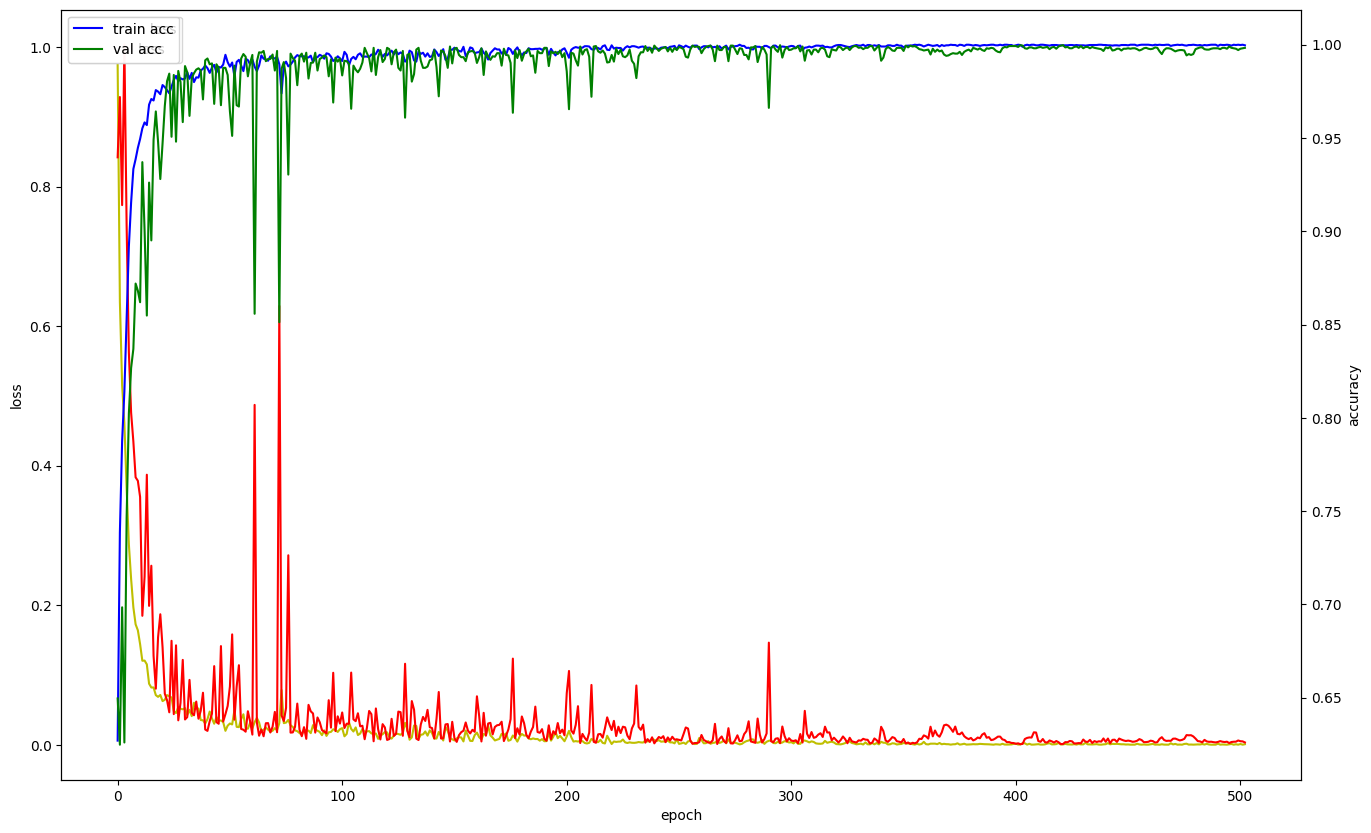

In [20]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()


loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [21]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)
# print(y_pred.shape)
# print(y_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

132/132 [==============================] - 0s 1ms/step


array([[[3093,    0],
        [   0, 1102]],

       [[3227,    0],
        [   1,  967]],

       [[3052,    0],
        [   0, 1143]],

       [[3212,    1],
        [   0,  982]]], dtype=int64)

In [26]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

test_data = np.load("dataset/confusion_matrix/seq_fall-2023-1.npy")

test_data = np.nan_to_num(test_data)
test_x = test_data[:, :, :-1]
test_y = test_data[:, 0, -1]


test_y = to_categorical(test_y, num_classes=len(actions))

y_pred = model.predict(test_x)
print(np.argmax(y_pred, axis=1))
print(np.argmax(test_y, axis=1))

print(test_y.shape)
print(y_pred.shape)

confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))


1/1 [==============================] - 0s 104ms/step
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
(7, 5)
(7, 5)


array([[7]], dtype=int64)